## OPENBIB - Working with BigQuery

In [1]:
from google.cloud import bigquery
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [17]:
openbib_inst = client.query(f"""
                            SELECT COUNT(DISTINCT(oal.doi)) AS n, LOWER(oal.ror) AS oal_ror, LOWER(kb_inst.ror) AS kb_ror, sector
                            FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst, UNNEST(kb_sector_id) AS sector
                            JOIN (
                              SELECT o.doi, inst.ror
                              FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                              WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                            ) AS oal
                              ON LOWER(inst.doi) = LOWER(oal.doi)
                            JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                              ON inst.kb_inst_id = kb_inst.kb_inst_id
                            GROUP BY oal_ror, kb_ror, sector
                            """).to_dataframe()

In [18]:
oal_ror = openbib_inst.groupby(['oal_ror', 'sector'])['n'].sum().reset_index()
kb_ror = openbib_inst.groupby(['kb_ror', 'sector'])['n'].sum().reset_index()

openbib_inst_plot = oal_ror.merge(kb_ror, left_on=['oal_ror', 'sector'], right_on=['kb_ror', 'sector'], how='inner', suffixes=('_oal', '_kb'))
openbib_inst_plot = openbib_inst_plot[openbib_inst_plot.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])]

openbib_inst_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

openbib_inst_plot.sort_values(by=['sector'], ascending=False, inplace=True)

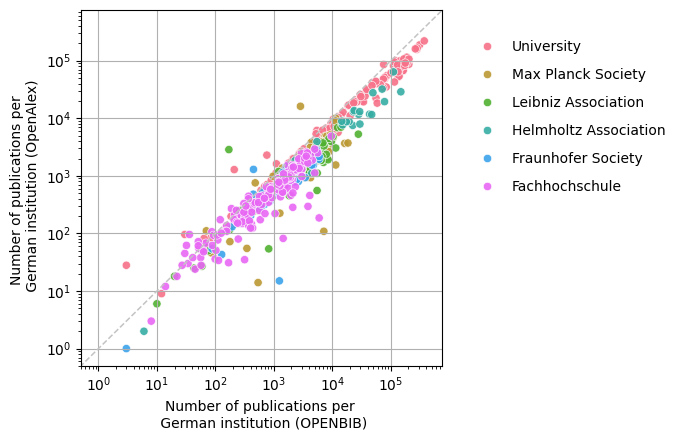

In [19]:
fig, ax = plt.subplots(figsize=(7, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_plot,
                x='n_kb',
                y='n_oal',
                hue='sector',
                alpha=0.9,
                palette='husl')

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

ax.legend(bbox_to_anchor=(1.05, 0.95),
          frameon=False,
          labelspacing=1.0)

plt.tight_layout()
plt.show()
fig.savefig('kb_institution_disambiguation.png', format='png', bbox_inches='tight', dpi=500)

In [37]:
openbib_inst_all = client.query(f"""
                                SELECT COUNT(DISTINCT(oal.doi)) AS n, LOWER(oal.ror) AS oal_ror, LOWER(kb_inst.ror) AS kb_ror
                                FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                JOIN (
                                  SELECT DISTINCT o.doi, inst.ror
                                  FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                                  WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                                ) AS oal
                                  ON LOWER(inst.doi) = LOWER(oal.doi)
                                JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                  ON inst.kb_inst_id = kb_inst.kb_inst_id
                                GROUP BY oal_ror, kb_ror
                                """).to_dataframe()

In [38]:
oal_ror = openbib_inst_all.groupby(['oal_ror'])['n'].sum().reset_index()
kb_ror = openbib_inst_all.groupby(['kb_ror'])['n'].sum().reset_index()

openbib_inst_all_plot = oal_ror.merge(kb_ror, left_on=['oal_ror'], right_on=['kb_ror'], how='inner', suffixes=('_oal', '_kb'))

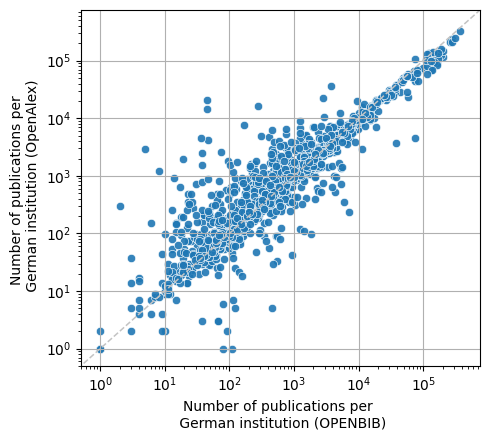

In [39]:
fig, ax = plt.subplots(figsize=(5, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_all_plot,
                x='n_kb',
                y='n_oal',
                alpha=0.9)

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

plt.tight_layout()
plt.show()
#fig.savefig('kb_institution_disambiguation_all.png', format='png', bbox_inches='tight', dpi=500)

In [15]:
openbib_inst_oal_type = client.query(f"""
                                     SELECT COUNT(DISTINCT(oal.doi)) AS n, LOWER(oal.ror) AS oal_ror, LOWER(kb_inst.ror) AS kb_ror, sector
                                     FROM `subugoe-collaborative.openbib.kb_a_addr_inst` AS inst
                                     JOIN (
                                       SELECT DISTINCT o.doi, inst.ror, inst.type AS sector
                                       FROM `subugoe-collaborative.openalex.works` AS o, UNNEST(authorships) AS aut, UNNEST(aut.institutions) AS inst
                                       WHERE inst.country_code = 'DE' AND publication_year BETWEEN 2014 AND 2024
                                     ) AS oal
                                       ON LOWER(inst.doi) = LOWER(oal.doi)
                                     JOIN `subugoe-collaborative.openbib.kb_inst` AS kb_inst
                                       ON inst.kb_inst_id = kb_inst.kb_inst_id
                                     GROUP BY oal_ror, kb_ror, sector
                                     """).to_dataframe()

In [24]:
oal_ror = openbib_inst_oal_type.groupby(['oal_ror', 'sector'])['n'].sum().reset_index()
kb_ror = openbib_inst_oal_type.groupby(['kb_ror', 'sector'])['n'].sum().reset_index()

openbib_inst_oal_type_plot = oal_ror.merge(kb_ror, left_on=['oal_ror', 'sector'], right_on=['kb_ror', 'sector'], how='inner', suffixes=('_oal', '_kb'))

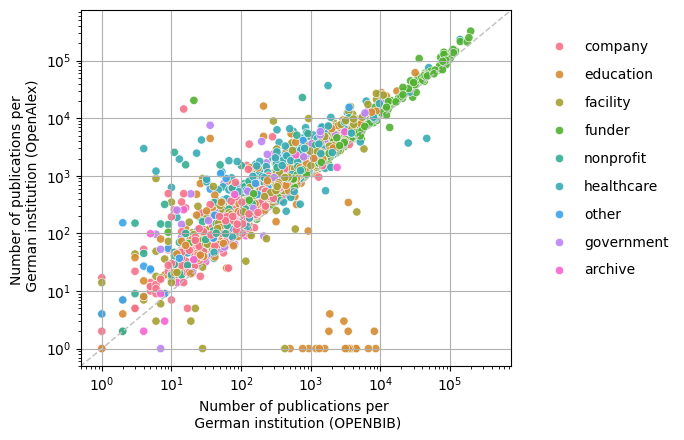

In [26]:
fig, ax = plt.subplots(figsize=(7, 4.5))

x = [x for x in range(-1000, 1000000, 10000)]
y = x

plt.grid(True)

sns.scatterplot(data=openbib_inst_oal_type_plot,
                x='n_kb',
                y='n_oal',
                hue='sector',
                alpha=0.9,
                palette='husl')

sns.lineplot(x=x, 
             y=y, 
             color='#c3c3c3', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(2**-1, 15**5)
ax.set_ylim(2**-1, 15**5)

plt.xscale('log')
plt.yscale('log')

ax.set(xlabel='Number of publications per \n German institution (OPENBIB)', 
       ylabel='Number of publications per \n German institution (OpenAlex)')

ax.legend(bbox_to_anchor=(1.05, 0.95),
          frameon=False,
          labelspacing=1.0)

plt.tight_layout()
plt.show()
#fig.savefig('kb_institution_disambiguation_oal.png', format='png', bbox_inches='tight', dpi=500)

In [5]:
doc_sectors_df = client.query(f"""
                              SELECT COUNT(DISTINCT(dt.doi)) AS n, kb_inst_id AS institution, sector, is_research
                              FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector
                              JOIN subugoe-collaborative.openbib.document_types AS dt
                                  ON LOWER(dt.doi) = LOWER(kb_a.doi)
                              GROUP BY sector, institution, is_research
                              """
                              ).to_dataframe()

In [57]:
doc_sectors_df_uni_is_research = doc_sectors_df[(doc_sectors_df.sector=='uni') & (doc_sectors_df.is_research==True)].groupby(['institution'])['n'].sum().reset_index()
doc_sectors_df_uni_all = doc_sectors_df[doc_sectors_df.sector=='uni'].groupby(['institution'])['n'].sum().reset_index()
doc_sectors_df_uni = doc_sectors_df_uni_all.merge(doc_sectors_df_uni_is_research, on='institution', suffixes=('_all', '_is_research'))

In [58]:
doc_sectors_df_is_research = doc_sectors_df[doc_sectors_df.is_research==True].groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_all = doc_sectors_df.groupby(['institution', 'sector'])['n'].sum().reset_index()
doc_sectors_df_plot = doc_sectors_df_all.merge(doc_sectors_df_is_research, on=['institution', 'sector'], suffixes=('_all', '_is_research'))

In [59]:
doc_sectors_df_plot = doc_sectors_df_plot[doc_sectors_df_plot.sector.isin(['uni', 'wgl', 'hgf', 'fh', 'mpg', 'fhg'])]
doc_sectors_df_plot = doc_sectors_df_plot.replace('uni', 'University')
doc_sectors_df_plot = doc_sectors_df_plot.replace('wgl', 'Leibniz Association')
doc_sectors_df_plot = doc_sectors_df_plot.replace('hgf', 'Helmholtz Association')
doc_sectors_df_plot = doc_sectors_df_plot.replace('fh', 'Fachhochschule')
doc_sectors_df_plot = doc_sectors_df_plot.replace('mpg', 'Max Planck Society')
doc_sectors_df_plot = doc_sectors_df_plot.replace('fhg', 'Fraunhofer Society')

doc_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

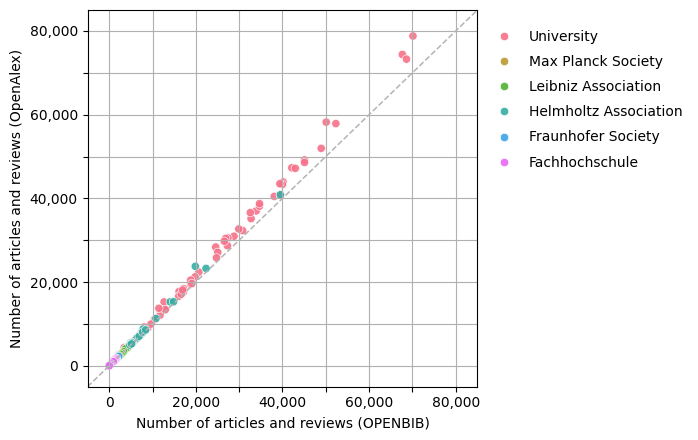

In [66]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-5000, 90000, 5000)]
y = x    
    
sns.scatterplot(data=doc_sectors_df_plot, 
                x='n_is_research', 
                y='n_all',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-5000, 85000)
ax.set_ylim(-5000, 85000)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of articles and reviews (OPENBIB)', ylabel='Number of articles and reviews (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
fig.savefig('document_types_sectors.png', format='png', bbox_inches='tight', dpi=500)

In [4]:
doc_sectors_type_df = client.query(f"""
                                    SELECT COUNT(DISTINCT(dt.doi)) AS n, is_research, inst.type AS inst_type
                                    FROM `subugoe-collaborative.openalex.works` AS oal, UNNEST(authorships) AS aut, UNNEST(aut.institutions) As inst
                                    JOIN subugoe-collaborative.openbib.document_types AS dt
                                        ON LOWER(dt.doi) = LOWER(oal.doi)
                                    GROUP BY inst_type, is_research
                                    """
                                    ).to_dataframe()

In [5]:
doc_sectors_type_df_all = doc_sectors_type_df.groupby(['inst_type'])['n'].sum().reset_index()
doc_sectors_type_df = doc_sectors_type_df.merge(doc_sectors_type_df_all, on='inst_type', suffixes=('', '_all'))
doc_sectors_type_df['prop'] = doc_sectors_type_df['n'] / doc_sectors_type_df['n_all']

In [8]:
doc_sectors_type_df[doc_sectors_type_df.is_research==False].sort_values(by='prop', ascending=False)

,n,is_research,inst_type,n_all,prop
1,871560,False,healthcare,6829115,0.127624
8,141051,False,company,1192634,0.118268
17,172064,False,nonprofit,1635329,0.105217
4,71515,False,other,775424,0.092227
15,12814,False,archive,168537,0.076031
0,567235,False,education,8067541,0.070311
2,1709672,False,funder,27482007,0.062211
9,212026,False,facility,3750499,0.056533
14,185540,False,government,3354529,0.05531


In [19]:
funders_sectors_df = client.query(f"""
                                  SELECT COUNT(DISTINCT(openbib_funding.doi)) AS f_n, 
                                         COUNT(DISTINCT(oal_funding.doi)) AS oal_n,
                                         institution, 
                                         sector
                                  FROM (
                                      SELECT f.doi
                                      FROM subugoe-collaborative.openbib.funding_information AS f
                                  ) AS openbib_funding
                                  LEFT JOIN (
                                      SELECT oal.doi
                                      FROM subugoe-collaborative.openalex.works AS oal, UNNEST(grants) AS grant
                                      JOIN subugoe-collaborative.openbib.funding_information AS f
                                          ON LOWER(f.doi) = LOWER(oal.doi)
                                      WHERE grant.funder_display_name = 'Deutsche Forschungsgemeinschaft'
                                  ) AS oal_funding
                                      ON LOWER(openbib_funding.doi) = LOWER(oal_funding.doi)
                                  JOIN (
                                    SELECT kb_a.doi AS kb_doi, kb_inst_id AS institution, sector
                                    FROM subugoe-collaborative.openbib.kb_a_addr_inst AS kb_a, UNNEST(kb_sector_id) AS sector  
                                    JOIN subugoe-collaborative.openbib.funding_information AS f
                                      ON LOWER(f.doi) = LOWER(kb_a.doi)
                                  ) AS kb_inst
                                      ON LOWER(openbib_funding.doi) = LOWER(kb_inst.kb_doi)
                                  GROUP BY institution, sector
                                  """
                                  ).to_dataframe()

In [23]:
funders_sectors_df_plot = funders_sectors_df[funders_sectors_df.sector.isin(['uni', 'fh', 'hgf', 'fhg', 'mpg', 'wgl'])].copy()

funders_sectors_df_plot.replace(dict(
    uni='University',
    fh='Fachhochschule',
    mpg='Max Planck Society',
    hgf='Helmholtz Association',
    fhg='Fraunhofer Society',
    wgl='Leibniz Association'
), inplace=True)

funders_sectors_df_plot.sort_values(by=['sector'], ascending=False, inplace=True)

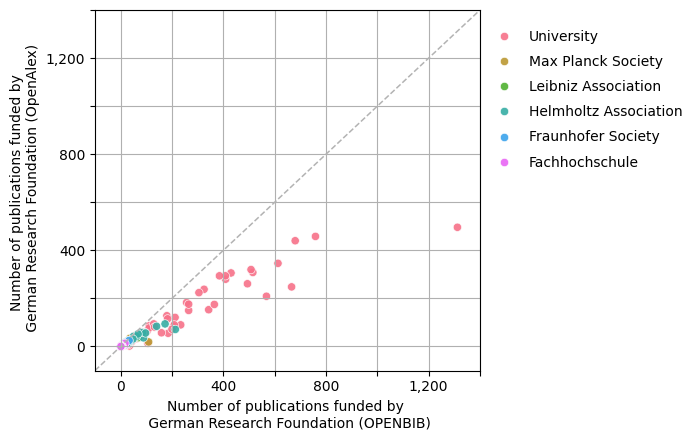

In [29]:
fig, ax = plt.subplots(figsize=(5, 4.5))

plt.grid(True)

x = [x for x in range(-100, 1500, 100)]
y = x    
    
sns.scatterplot(data=funders_sectors_df_plot, 
                x='f_n', 
                y='oal_n',
                alpha=0.9,
                palette='husl',
                hue='sector')

sns.lineplot(x=x, 
             y=y, 
             color='#b3b3b3a0', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set_xlim(-100, 1400)
ax.set_ylim(-100, 1400)

ax.get_legend().remove()

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.setp(ax.get_xticklabels()[::2], visible=False)
plt.setp(ax.get_yticklabels()[::2], visible=False)

ax.set(xlabel='Number of publications funded by \n German Research Foundation (OPENBIB)', 
       ylabel='Number of publications funded by \n German Research Foundation (OpenAlex)')

lgd = fig.legend(frameon=False, 
                 bbox_to_anchor=(1.4, 0.95),
                 labelspacing=0.8)

plt.tight_layout()
plt.show()
fig.savefig('funding_information_sectors.png', format='png', bbox_inches='tight', dpi=500)